In [21]:
import numpy as np
import PIL
import tensorflow as tf
import os
import pickle
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.python.keras import layers
from tensorflow.python.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix

print(tf.config.list_physical_devices("GPU"))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [22]:
# hyper-parameters
batch_size = 16
img_size = 150
main_epochs = 5
fine_tune_epochs = 6
dataset = "crc"
data_path = f"data/{dataset}/decomposed_split/inception"
train_path = data_path + '/train/'
val_path = data_path + '/val/'

In [23]:
# declaring functions for creating model, training, fine-tuning and testing
def create_model(base):
    base_model = base  # Do not include the ImageNet classifier at the top.
    # Freeze the base_model
    base_model.trainable = False
    # Create new model on top
    inputs = keras.Input(shape=(img_size, img_size, 3))
    x = inputs
    scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
    x = scale_layer(x)
    x = base_model(x, training=False)
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
    outputs = keras.layers.Dense(num_classes)(x)
    model = keras.Model(inputs, outputs)
    return model


def train_top_layer(model):
    print('-----Initial Training-----')
    # compiles model
    model.compile(
        optimizer='adam',
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy'],
    )

    epochs = main_epochs
    # model is trained on training data
    history = model.fit(train_ds, epochs=epochs, validation_data=val_ds)
    # trained model is returned
    return model, history


def fine_tune_model(model):
    print('-----Fine Tuning-----')
    # unfreezing base layers
    base_model.trainable = True

    # compiling model with low learning rate
    model.compile(
        optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy'],
    )

    # whole model is re-trained on new data
    epochs = fine_tune_epochs
    history = model.fit(train_ds, epochs=epochs, validation_data=val_ds)
    # trained model is returned
    return model, history


def get_aug_test_accuracy(model):
    accuracy = model.evaluate(aug_test_ds, verbose=0)
    return accuracy[1]

In [24]:
# loading training and validation data
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_path,
    seed=123,
    label_mode='int',
    image_size=(img_size, img_size),
    batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_path,
    seed=123,
    label_mode='int',
    image_size=(img_size, img_size),
    batch_size=batch_size)

class_names = train_ds.class_names
num_classes = len(class_names)

Found 27952 files belonging to 8 classes.
Found 6986 files belonging to 8 classes.


In [25]:
# initial pre-preprocessing
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

-----Initial Training-----
Epoch 1/5
1747/1747 [==============================] - 32s 13ms/step - loss: 0.3625 - accuracy: 0.8672 - val_loss: 0.2691 - val_accuracy: 0.8952
Epoch 2/5
1747/1747 [==============================] - 20s 11ms/step - loss: 0.2738 - accuracy: 0.8939 - val_loss: 0.2338 - val_accuracy: 0.9072
Epoch 3/5
1747/1747 [==============================] - 20s 11ms/step - loss: 0.2555 - accuracy: 0.9007 - val_loss: 0.2339 - val_accuracy: 0.9064
Epoch 4/5
1747/1747 [==============================] - 20s 11ms/step - loss: 0.2448 - accuracy: 0.9020 - val_loss: 0.2334 - val_accuracy: 0.9102
Epoch 5/5
1747/1747 [==============================] - 21s 12ms/step - loss: 0.2391 - accuracy: 0.9079 - val_loss: 0.2262 - val_accuracy: 0.9131


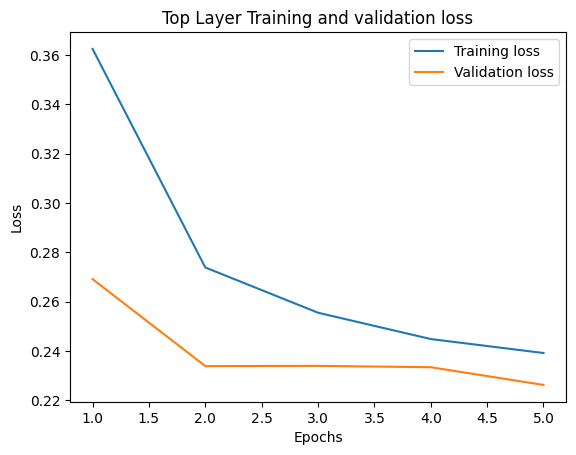

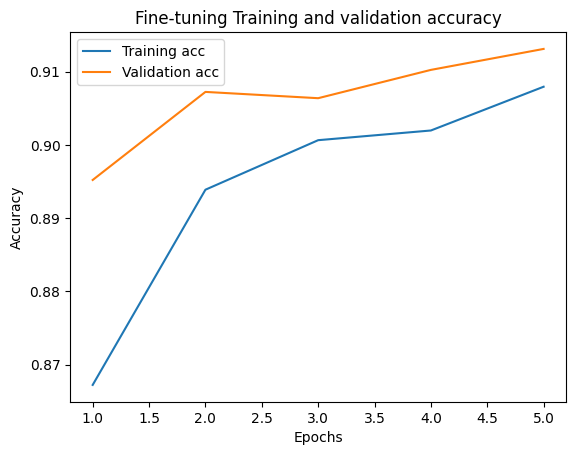

-----Fine Tuning-----
Epoch 1/6
1747/1747 [==============================] - 66s 36ms/step - loss: 0.2026 - accuracy: 0.9170 - val_loss: 0.1685 - val_accuracy: 0.9343
Epoch 2/6
1747/1747 [==============================] - 64s 36ms/step - loss: 0.1297 - accuracy: 0.9455 - val_loss: 0.1307 - val_accuracy: 0.9500
Epoch 3/6
1747/1747 [==============================] - 60s 34ms/step - loss: 0.0828 - accuracy: 0.9676 - val_loss: 0.1221 - val_accuracy: 0.9593
Epoch 4/6
1747/1747 [==============================] - 59s 34ms/step - loss: 0.0505 - accuracy: 0.9806 - val_loss: 0.1437 - val_accuracy: 0.9571
Epoch 5/6
1747/1747 [==============================] - 61s 35ms/step - loss: 0.0311 - accuracy: 0.9886 - val_loss: 0.1530 - val_accuracy: 0.9598
Epoch 6/6
1747/1747 [==============================] - 66s 38ms/step - loss: 0.0237 - accuracy: 0.9916 - val_loss: 0.1528 - val_accuracy: 0.9602


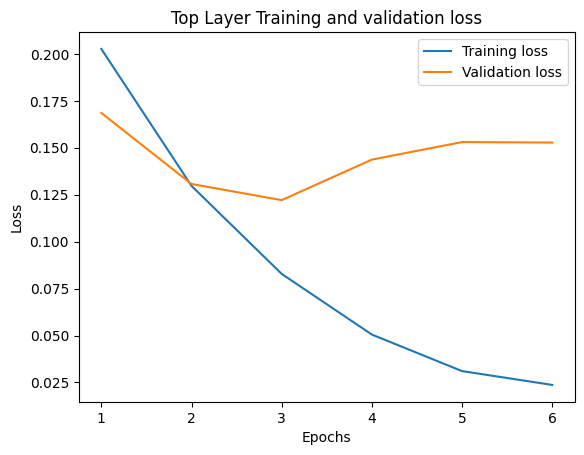

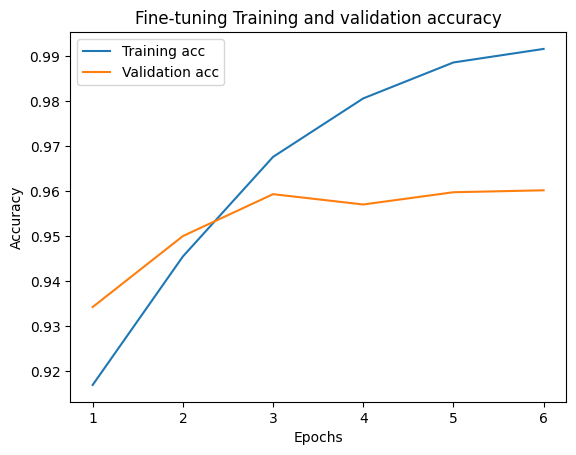

In [26]:
base_model = keras.applications.Xception(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(img_size, img_size, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

model = create_model(base_model)
model, history = train_top_layer(model)
# plot results of experiment
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['accuracy']
epochs = range(1, len(acc_values) + 1)
plt.plot(epochs, loss_values, label='Training loss')
plt.plot(epochs, val_loss_values, label='Validation loss')
plt.title('Top Layer Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.clf()
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
plt.plot(epochs, acc_values, label='Training acc')
plt.plot(epochs, val_acc_values, label='Validation acc')
plt.title('Fine-tuning Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
model, history = fine_tune_model(model)
# plot results of experiment
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['accuracy']
epochs = range(1, len(acc_values) + 1)
plt.plot(epochs, loss_values, label='Training loss')
plt.plot(epochs, val_loss_values, label='Validation loss')
plt.title('Top Layer Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.clf()
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
plt.plot(epochs, acc_values, label='Training acc')
plt.plot(epochs, val_acc_values, label='Validation acc')
plt.title('Fine-tuning Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
filename = f"{dataset}_model.h5"
model.save(filename)

In [27]:
# loading in pre-trained verification model
dataset = 'crc'
data_path = f"data/{dataset}/decomposed_split/inception"
aug_test_path = data_path + '/val/'
model = tf.keras.models.load_model(f"{dataset}_model.h5")
# loading in testing set of fully synthesised images
aug_test_ds = tf.keras.utils.image_dataset_from_directory(
    aug_test_path,
    seed=123,
    label_mode='int',
    image_size=(img_size, img_size),
    batch_size=batch_size)
# getting classification accuracy
accuracy = round(get_aug_test_accuracy(model), 3)
print(f"Augmented Testing Set Accuracy: {accuracy}")

Found 6986 files belonging to 8 classes.
Augmented Testing Set Accuracy: 0.96
